In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.isokann.modules import scale_and_shift, NeuralNetwork, trainNN

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)


Created variables:
out_trajectories = output/trajectories/
out_isokann = output/isokann/
out_mokito = output/MKM/

cuda


In [2]:
# Load initial and final states and convert to torch
X0       = pt.tensor(np.load(out_trajectories + 'X0.npy'), dtype=pt.float32).to(device)
Xt       = pt.tensor(np.load(out_trajectories + 'Xt.npy'), dtype=pt.float32).to(device)

# Number of dimensions
Nd       = X0.shape[1]

In [3]:
# Define the NN
lr = 1e-2
wd = 1e-5
Nepochs = 10
batch_size=100

NNnodes = np.array([Nd, 32, 1])
np.savetxt(out_isokann + 'NNnodes.txt', NNnodes)

f_NN = NeuralNetwork( Nodes = NNnodes, enforce_positive = 0 ).to(device)

Niters = 30

train_LOSS = np.empty(0, dtype = object)
val_LOSS   = np.empty(0, dtype = object)

for k in tqdm(range(Niters)):
    f_k                             =  f_NN(Xt)
    mean_f_k                        =  pt.mean(f_k, axis=1)
    f_k1                            =  scale_and_shift(mean_f_k).to(device)
    f_k1                            =  f_k1.clone().detach().requires_grad_(False)
    train_loss, val_loss, best_loss = trainNN(net = f_NN, lr = lr, wd = wd, Nepochs = Nepochs, batch_size=batch_size, X=X0, Y=f_k1)
    train_LOSS                      = np.append(train_LOSS, train_loss[-1]) #[-1]
    val_LOSS                        = np.append(val_LOSS, val_loss[-1])     # [-1]


100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


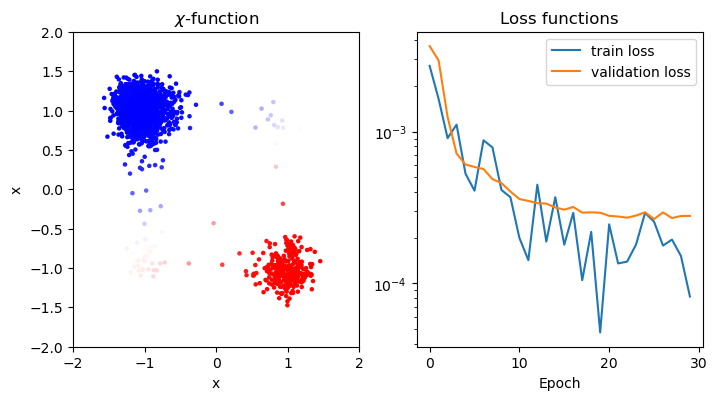

In [4]:
npX0 = X0.cpu().detach().numpy()
chi  = f_NN(X0).cpu().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(16*in2cm, 8*in2cm), facecolor='white')


pos = ax[0].scatter( npX0[:,0], npX0[:,1], c = chi,  cmap = cm.bwr , s = 5 )

ax[0].set_title('$\chi$-function')
ax[0].set_ylim((-2,2))
ax[0].set_xlim((-2,2))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')


ax[1].plot(train_LOSS, label='train loss')
ax[1].plot(val_LOSS, label='validation loss')
ax[1].semilogy()
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss functions')
ax[1].legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('chi.png', format='png', dpi=900, bbox_inches='tight')

In [5]:
pt.save(f_NN.state_dict(), out_isokann  + 'f_NN.pt')
np.savetxt(out_isokann  + 'val_LOSS.txt', val_LOSS)
np.savetxt(out_isokann  + 'train_LOSS.txt', train_LOSS)
np.save(out_isokann + 'chi0.npy', chi)

# Calculate propagated chi
#chit = f_NN(Xtau).cpu().detach().numpy()
#np.save(out_isokann + 'chit.npy', chit)
